(ex_tracing_tn_functions)=

# Tracing tensor network functions and reusing intermediates

This example shows how to use {mod}`autoray.lazy` to lazily 'trace' a tensor network function. One can then inspect the computational graph or optionally compute it using automatically indentified shared intermediates.

```{hint}
See the main [`autoray` lazy computation docs here](https://autoray.readthedocs.io/en/latest/lazy_computation.html) for the full range of functionality.
```

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import autoray as ar

We'll use the basic example of evaluating a two-site observable at every adjacent pair in an MPS (using a MPO expectation or manually reusing environments would be the most efficient way of doing this usually):

In [2]:
mps = qtn.MPS_rand_state(20, 10)
G = qu.rand_herm(4, dtype="float64")

First the eager computation:

In [3]:
%%time
ex_eager = sum(
    mps.local_expectation_exact(G, (i, i + 1))
    for i in range(mps.L - 1)
)
ex_eager

CPU times: user 49.1 ms, sys: 2.49 ms, total: 51.6 ms
Wall time: 91.5 ms


np.float64(-2.1507695767849517)

## Lazily tracing the computation

Now we can wrap all the underlying arrays as {class}`autoray.lazy.LazyArray` instances:

In [4]:
mps.apply_to_arrays(ar.lazy.array)
lG = ar.lazy.array(G)

Now we when call the same expectation, the operations are only traced:

In [5]:
ex_lazy = sum(
    mps.local_expectation_exact(lG, (i, i + 1))
    for i in range(mps.L - 1))
ex_lazy

<LazyArray(fn=add, shape=(), backend='numpy')>

That allows us to perform introspection, like the mix of array functions used:

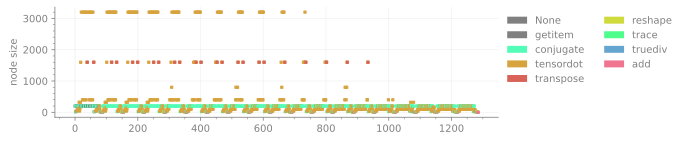

In [6]:
ex_lazy.plot_history_functions();

Or the rough memory footprint in terms of concurrent array elements:

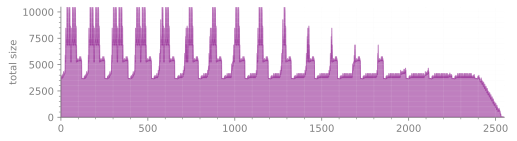

In [7]:
ex_lazy.plot_history_size_footprint();

We can compute the actual value by calling [`.compute()`](autoray.lazy.LazyArray.compute), though note this also clears the computational graph, so you should do any introspection first:

In [8]:
%%time
ar.lazy.compute(ex_lazy)

CPU times: user 13.9 ms, sys: 2.17 ms, total: 16 ms
Wall time: 18.2 ms


np.float64(-2.1507695767849517)

The computation is faster as only the numeric operations are run, all the `quimb` infrastructure that essentially composed the computation ran earlier.

## Reusing intermediates:

One thing that lazily tracing allows is automatic identification of any repeated intermediates (without blindly caching everything):

In [9]:
with ar.lazy.shared_intermediates():
    ex_lazy_reuse = sum(
        mps.local_expectation_exact(lG, (i, i + 1))
        for i in range(mps.L - 1)
    )

Now we we look at the functions used it should be a far shorter list:

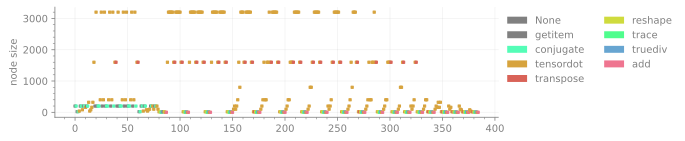

In [10]:
ex_lazy_reuse.plot_history_functions();

Though the memory footprint might also go up:

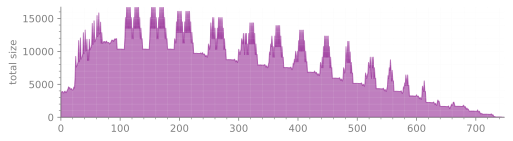

In [11]:
ex_lazy_reuse.plot_history_size_footprint();

Note we haven't done anything to favor reuse in the computation here, so slightly different contraction orders might prevent efficient use for example. Generally for best performance one would want to either explicitly favor repeated patterns to maximize cache reuse, or setup intermedates / environments explicitly.

Again, we can just call `.compute()` to get the value, and it should be slightly quicker:

In [12]:
%%time
ar.lazy.compute(ex_lazy_reuse)

CPU times: user 6.77 ms, sys: 1.28 ms, total: 8.04 ms
Wall time: 15.3 ms


np.float64(-2.1507695767849517)

## Compiling the computation

For repeated computations one can use `autoray` to set up a pure 'array function'.

In [13]:
# rebuild our computational graph
with ar.lazy.shared_intermediates():
    output = sum(
        mps.local_expectation_exact(G, (i, i + 1))
        for i in range(mps.L - 1)
    )

In [14]:
# get the function from the input variables to this output
# note that `G` will be treated as constant since we don't supply it here
inputs = list(mps.arrays)
foo = output.get_function(inputs)

Now we can supply any set of matching arrays to this function. And now only the array functions will be called in a `exec` compiled block:

In [15]:
# get a new TN with matching arrays
mps2 = qtn.MPS_rand_state(20, 10)

In [16]:
%%time
foo(mps2.arrays)

CPU times: user 5.7 ms, sys: 1.7 ms, total: 7.41 ms
Wall time: 8.82 ms


np.float64(-2.2266568847709034)

Note the order of the arrays and array axes must match the original computation.

Alternatively one can just `ar.autojit` to automate this process, and also use different backends. `autojit` automatically reuses shared intermediates and folds constants.

In [17]:
@ar.autojit
def bar(arrays, G):
    mps_trace = mps2.copy()
    for t, ary in zip(mps_trace, arrays):
        t.modify(data=ary)
    return sum(
        mps_trace.local_expectation_exact(G, (i, i + 1))
        for i in range(mps.L - 1)
    )

This is also the general setup for using other tracing decorators.

In [ ]:
%%time
# first time there will be some overhead from tracing
bar(mps2.arrays, G)

CPU times: user 52.5 ms, sys: 3.89 ms, total: 56.4 ms
Wall time: 69.8 ms


np.float64(-2.2266568847709034)

In [ ]:
%%time
# second time it will be fast
bar(mps2.arrays, G)

CPU times: user 4.99 ms, sys: 1.62 ms, total: 6.61 ms
Wall time: 12.5 ms


np.float64(-2.2266568847709034)

Or we can use one of the other compilation backends:

In [20]:
%%time
bar(mps2.arrays, G, backend="jax")

CPU times: user 2.89 s, sys: 217 ms, total: 3.1 s
Wall time: 1.73 s


array(-2.226657, dtype=float32)

In [21]:
%%time
bar(mps2.arrays, G, backend="jax")

CPU times: user 1.62 ms, sys: 995 μs, total: 2.62 ms
Wall time: 2.03 ms


array(-2.226657, dtype=float32)

```{warning}
Note jax eagerly defaults to single precision unless configured otherwise.
```